In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from datasets import load_dataset
dataset = load_dataset(
            "InstaDeepAI/genomics-long-range-benchmark",
            task_name='bulk_rna_expression',
            sequence_length=2048,
            cache_dir='/liuzicheng/ljh/hyena-dna/data/genomic_long_range',
            trust_remote_code=True,
        )
train_dataset = dataset['train']
test_dataset = dataset['test']


all_seqs=test_dataset['sequence']
all_labels=test_dataset['labels']
all_Chromosome=test_dataset['chromosome']
batch_size=1


  
from scipy.stats import pearsonr
from scipy import stats

def spearmanr(logits,y):
    #compute spearmanr correlation for each class
    output={}
    logits = logits.detach().cpu().numpy()
    y = y.detach().cpu().numpy()
    metrices = []
    for i in range(logits.shape[0]):
        spearmanrs = stats.spearmanr(logits[i, :], y[i, :])[0]
        metrices.append(spearmanrs)
    spearmanrs=np.nanmean(metrices,axis=0)
    output['spearmanr']=spearmanrs
    return output

/liuzicheng/anaconda3/envs/evo-design/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def spearmanr(logits,y):
    #compute spearmanr correlation for each class
    output={}
    logits = logits.detach().cpu().numpy()
    y = y.detach().cpu().numpy()
    metrices = []
    for i in range(logits.shape[1]):
        spearmanrs = stats.spearmanr(logits[:, i], y[:, i])[0]
        metrices.append(spearmanrs)
    spearmanrs=np.nanmean(metrices,axis=0)
    output['spearmanr']=spearmanrs
    
    return output

def mse(logits,y):
    #compute mse for each class
    output={}
    logits = logits.detach().cpu().numpy()
    y = y.detach().cpu().numpy()
    metrices = []
    for i in range(logits.shape[0]):
        mse = np.mean((logits[i, :] - y[i, :]) ** 2)
        metrices.append(mse)
    mse=np.nanmean(metrices,axis=0)
    output['mse']=mse

    return output

def R2(logits,y):
    from sklearn.metrics import r2_score
    #compute R2 for each class
    logits = logits.detach().cpu().numpy()
    y = y.detach().cpu().numpy()
    metrices = []
    for i in range(logits.shape[1]):
        r2s = r2_score(y[:, i], logits[:, i])
        metrices.append(r2s)
    r2s=np.nanmean(metrices,axis=0)
    return r2s

In [4]:
from transformers import AutoTokenizer,AutoModel
from torch import nn
from einops.layers.torch import Rearrange

state_dict='/liuzicheng/ljh/hyena-dna/weight/hyenadna/hyenadna-large-1m-seqlen'
d_model=256
max_length=2048

class hyena_model(nn.Module):
    def __init__(self):
        super(hyena_model, self).__init__()
        self.backbone=AutoModel.from_pretrained(state_dict, trust_remote_code=True).to('cuda')
        self.output_transform = nn.Linear(d_model, 218)
        self.linear = nn.Linear(2048,1)
        # self.final_pointwise = nn.Sequential(
        #     Rearrange('b n d -> b d n'),
        #     ConvBlock(d_model, d_model*2, 1),
        #     Rearrange('b d n -> b n d'),
        #     GELU()
        # )
        
        self.activation=nn.Softplus()
    
    def forward(self,input_ids,mask=None):
        hidden_state=self.backbone(input_ids).last_hidden_state
        if mask is None:
                restrict = lambda x: (
                    torch.cumsum(x, dim=-2)
                    / torch.arange(
                        1, 1 + x.size(-2), device=x.device, dtype=x.dtype
                    ).unsqueeze(-1)
                )[..., -1:, :]           
        else:
                # sum masks
                mask_sums = torch.sum(mask, dim=-1).squeeze() - 1  # for 0 indexing

                # convert mask_sums to dtype int
                mask_sums = mask_sums.type(torch.int64)

                restrict = lambda x: (
                    torch.cumsum(x, dim=-2)
                    / torch.arange(
                        1, 1 + x.size(-2), device=x.device, dtype=x.dtype
                    ).unsqueeze(-1)
                )[torch.arange(x.size(0)), mask_sums, :].unsqueeze(1)  # need to keep original shape
        
        # hidden_state= (torch.cumsum(hidden_state, dim=-2)
        #             / torch.arange(
        #                 1, 1 + hidden_state.size(-2), device=hidden_state
        #                 .device, dtype=hidden_state.dtype
        #             ).unsqueeze(-1)
        #         )[..., -1:, :]    
        hidden_state=restrict(hidden_state)       
        hidden_state = self.output_transform(hidden_state)
        output = hidden_state.squeeze(1)

        return output


# checkpoint=torch.load('/liuzicheng/ljh/hyena-dna/outputs/2024-05-07/08-38-59-295242/checkpoints/val/spearmanr.ckpt')['state_dict']
checkpoint=torch.load('/liuzicheng/ljh/hyena-dna/outputs/2024-05-09/04-54-29-787887/checkpoints/val/spearmanr.ckpt')['state_dict']
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            checkpoint, "model."
        )
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            checkpoint, "decoder.0."
        )
hyena=hyena_model().to('cuda')
hyena.load_state_dict(checkpoint,strict=False)



_IncompatibleKeys(missing_keys=[], unexpected_keys=['lm_head.weight'])

In [5]:
from transformers import AutoTokenizer,AutoModel
import torch
from torch import nn


with torch.no_grad():
    state_dict='/liuzicheng/ljh/hyena-dna/weight/hyenadna/hyenadna-large-1m-seqlen'
    hyena_tokenizer=AutoTokenizer.from_pretrained(state_dict, trust_remote_code=True)
    

    target_list=[]
    seq_list=[]
    for i in range(len(all_seqs)):
        sequence_encoded=hyena_tokenizer(all_seqs[i],
                            add_special_tokens= False,  # this is what controls adding eos
                            padding="max_length",
                            max_length=max_length,
                            truncation=True,
                        )
        seq_ids=sequence_encoded['input_ids']
        seq_ids = torch.LongTensor(seq_ids)
        target = all_labels[i][:1000]
        
        seqs=torch.reshape(seq_ids,(1,max_length)).to('cuda')
        target_list.append(target)
        
        out1=hyena(seqs)
        out1_hyena=out1.squeeze(1).squeeze(0).cpu().detach().numpy()
        
        seq_list.append(out1_hyena)
        seq_list_numpy_hyena=np.array(seq_list)

        target_list_numpy=np.array(target_list)
        seq_list_tensor=torch.FloatTensor(seq_list_numpy_hyena)
        target_list_tensor=torch.FloatTensor(target_list_numpy)
        #calculate the 
        if i>=1:
            
            
            
            spearmanr_value=R2(seq_list_tensor,target_list_tensor)
            print('R2:',spearmanr_value)
            spearmanr_value=spearmanr(seq_list_tensor,target_list_tensor)
            print('Pearsonr:',spearmanr_value)
            mse_out=mse(seq_list_tensor,target_list_tensor)
            print('mse:',mse_out)

#plot the bar plot of the pearsonr


R2: -50305.275266782686
Pearsonr: {'spearmanr': 0.7870370370370369}
mse: {'mse': 0.5185307}
R2: -0.8656264929760221


/tmp/ipykernel_1217/3003857739.py:8: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  spearmanrs = stats.spearmanr(logits[:, i], y[:, i])[0]


Pearsonr: {'spearmanr': 0.6799635358145362}
mse: {'mse': 0.48130998}
R2: -0.16330631638252663
Pearsonr: {'spearmanr': 0.5141584774560695}
mse: {'mse': 0.43066555}
R2: 0.2603536879120817
Pearsonr: {'spearmanr': 0.756177802907125}
mse: {'mse': 1.4671905}
R2: 0.26136355952942825
Pearsonr: {'spearmanr': 0.7193770327809598}
mse: {'mse': 1.2468338}
R2: 0.25559904716578513
Pearsonr: {'spearmanr': 0.6181800537822709}
mse: {'mse': 1.1215011}
R2: 0.2822239156300303
Pearsonr: {'spearmanr': 0.6723203425471206}
mse: {'mse': 1.1061578}
R2: 0.19764264434709355
Pearsonr: {'spearmanr': 0.5624291803460362}
mse: {'mse': 1.1938845}
R2: 0.17829363322473873
Pearsonr: {'spearmanr': 0.5314362176001951}
mse: {'mse': 1.1526082}
R2: 0.18114518081473185
Pearsonr: {'spearmanr': 0.5063392169706182}
mse: {'mse': 1.0737365}
R2: 0.19109034485870868
Pearsonr: {'spearmanr': 0.5315409079278534}
mse: {'mse': 0.9985531}
R2: 0.21886812657687332
Pearsonr: {'spearmanr': 0.5520781340470298}
mse: {'mse': 0.96671546}
R2: 0.27286

In [6]:
from transformers import AutoTokenizer,AutoModel
from torch import nn
from einops.layers.torch import Rearrange


max_length=2048
state_dict='/liuzicheng/ljh/hyena-dna/weight/dnabert2'
d_model=768
class bert2_model(nn.Module):
    def __init__(self):
        super(bert2_model, self).__init__()
        self.backbone=AutoModel.from_pretrained(state_dict, trust_remote_code=True).to('cuda')
        self.output_transform = nn.Linear(d_model, 218)
        self.linear = nn.Linear(2048,1)
        # self.final_pointwise = nn.Sequential(
        #     Rearrange('b n d -> b d n'),
        #     ConvBlock(d_model, d_model*2, 1),
        #     Rearrange('b d n -> b n d'),
        #     GELU()
        # )
        
        self.activation=nn.Softplus()
    
    def forward(self,input_ids,mask=None,encoder_attention_mask=None):
        hidden_state=self.backbone(input_ids=seqs,attention_mask=mask,encoder_attention_mask=encoder_attention_mask,export_hidden_states=True)[0]
        if mask is None:
                restrict = lambda x: (
                    torch.cumsum(x, dim=-2)
                    / torch.arange(
                        1, 1 + x.size(-2), device=x.device, dtype=x.dtype
                    ).unsqueeze(-1)
                )[..., -1:, :]           
        else:
                # sum masks
                mask_sums = torch.sum(mask, dim=-1).squeeze() - 1  # for 0 indexing

                # convert mask_sums to dtype int
                mask_sums = mask_sums.type(torch.int64)

                restrict = lambda x: (
                    torch.cumsum(x, dim=-2)
                    / torch.arange(
                        1, 1 + x.size(-2), device=x.device, dtype=x.dtype
                    ).unsqueeze(-1)
                )[torch.arange(x.size(0)), mask_sums, :].unsqueeze(1)  # need to keep original shape
        # hidden_state=self.linear(hidden_state.permute(0,2,1)).permute(0,2,1)
        hidden_state=restrict(hidden_state)
        # hidden_state = self.final_pointwise(hidden_state)
        hidden_state = self.output_transform(hidden_state)
        hidden_state=hidden_state.squeeze(-1)
        output = hidden_state.squeeze(1)

        return output



checkpoint=torch.load('/liuzicheng/ljh/hyena-dna/outputs/2024-05-08/16-58-19-542915/checkpoints/val/spearmanr.ckpt')['state_dict']
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            checkpoint, "model."
        )
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            checkpoint, "decoder.0."
        )
bert2=bert2_model().to('cuda')
bert2.load_state_dict(checkpoint,strict=False)

/root/.cache/huggingface/modules/transformers_modules/dnabert2/bert_layers.py:126: UserWarning: Unable to import Triton; defaulting MosaicBERT attention implementation to pytorch (this will reduce throughput when using this model).
  warnings.warn(
Some weights of BertModel were not initialized from the model checkpoint at /liuzicheng/ljh/hyena-dna/weight/dnabert2 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


_IncompatibleKeys(missing_keys=[], unexpected_keys=['lm_head.weight'])

In [7]:
from transformers import AutoTokenizer,AutoModel
import torch
from torch import nn


with torch.no_grad():
    bert2_tokenizer=AutoTokenizer.from_pretrained(state_dict, trust_remote_code=True)
    

    target_list=[]
    seq_list=[]
    for i in range(len(all_seqs)):
        sequence_encoded=bert2_tokenizer(all_seqs[i],
                            add_special_tokens= False,  # this is what controls adding eos
                            padding="max_length",
                            max_length=max_length,
                            truncation=True,
                        )
        seq_ids=sequence_encoded['input_ids']
        attention_mask=torch.BoolTensor(sequence_encoded['attention_mask']).int()
        seq_ids = torch.LongTensor(seq_ids)
        target = all_labels[i][:1000]
        
        seqs=torch.reshape(seq_ids,(1,max_length)).to('cuda')
        attention_mask=torch.reshape(attention_mask,(1,max_length)).to('cuda')
        target_list.append(target)
        
        out1=bert2(seqs,mask=attention_mask,encoder_attention_mask=attention_mask)
        out1_bert2=out1.squeeze(1).squeeze(0).cpu().detach().numpy()
        
        seq_list.append(out1_bert2)
        seq_list_numpy_bert2=np.array(seq_list)

        target_list_numpy=np.array(target_list)
        seq_list_tensor=torch.FloatTensor(seq_list_numpy_bert2)
        target_list_tensor=torch.FloatTensor(target_list_numpy)
        #calculate the 
            
            
        if i>1:
            spearmanr_value=R2(seq_list_tensor,target_list_tensor)
            print('R2:',spearmanr_value)
            spearmanr_value=spearmanr(seq_list_tensor,target_list_tensor)
            print('Pearsonr:',spearmanr_value)
            mse_out=mse(seq_list_tensor,target_list_tensor)
            print(mse_out)

#plot the bar plot of the pearsonr


/root/.cache/huggingface/modules/transformers_modules/dnabert2/bert_layers.py:433: UserWarning: Increasing alibi size from 512 to 2048
  warnings.warn(


R2: -0.5542911839092959
Pearsonr: {'spearmanr': 0.3934309595983079}
{'mse': 0.67781144}
R2: -0.23383112378278023
Pearsonr: {'spearmanr': 0.3293577981651376}
{'mse': 0.57670903}
R2: 0.14391271949064316
Pearsonr: {'spearmanr': 0.6638806346425924}
{'mse': 1.7096016}
R2: 0.14714426887108756
Pearsonr: {'spearmanr': 0.6433230372045725}
{'mse': 1.4497648}
R2: 0.13963464596537956
Pearsonr: {'spearmanr': 0.5149512530780394}
{'mse': 1.3067229}
R2: 0.18682705601689936
Pearsonr: {'spearmanr': 0.5992482106016008}
{'mse': 1.2691754}
R2: 0.07594950967330164
Pearsonr: {'spearmanr': 0.48194679423201003}
{'mse': 1.3865886}
R2: 0.026837159466718
Pearsonr: {'spearmanr': 0.43268959621986774}
{'mse': 1.3732767}
R2: 0.009976535960172825
Pearsonr: {'spearmanr': 0.36321305818006155}
{'mse': 1.306673}
R2: 0.022750184246114236
Pearsonr: {'spearmanr': 0.3986590836376208}
{'mse': 1.2138733}
R2: 0.07073869764531092
Pearsonr: {'spearmanr': 0.42686267598047367}
{'mse': 1.156514}
R2: 0.1449452770670952
Pearsonr: {'spe

In [8]:
from transformers import AutoTokenizer,AutoModel
from torch import nn
from einops.layers.torch import Rearrange


max_length=2048
state_dict='/liuzicheng/ljh/hyena-dna/weight/genalm/gena-lm-bigbird-base-t2t'
d_model=768
class genalm_model(nn.Module):
    def __init__(self):
        super(genalm_model, self).__init__()
        self.backbone=AutoModel.from_pretrained(state_dict, trust_remote_code=True).to('cuda')
        self.output_transform = nn.Linear(d_model, 218)
        self.linear = nn.Linear(2048,1)
        # self.final_pointwise = nn.Sequential(
        #     Rearrange('b n d -> b d n'),
        #     ConvBlock(d_model, d_model*2, 1),
        #     Rearrange('b d n -> b n d'),
        #     GELU()
        # )
        
        self.activation=nn.Softplus()
    
    def forward(self,input_ids,mask=None,encoder_attention_mask=None):
        hidden_state=self.backbone(input_ids=seqs, attention_mask=mask, encoder_attention_mask=encoder_attention_mask,output_hidden_states=True,).hidden_states[-1]
        if mask is None:
                restrict = lambda x: (
                    torch.cumsum(x, dim=-2)
                    / torch.arange(
                        1, 1 + x.size(-2), device=x.device, dtype=x.dtype
                    ).unsqueeze(-1)
                )[..., -1:, :]           
        else:
                # sum masks
                mask_sums = torch.sum(mask, dim=-1).squeeze() - 1  # for 0 indexing

                # convert mask_sums to dtype int
                mask_sums = mask_sums.type(torch.int64)

                restrict = lambda x: (
                    torch.cumsum(x, dim=-2)
                    / torch.arange(
                        1, 1 + x.size(-2), device=x.device, dtype=x.dtype
                    ).unsqueeze(-1)
                )[torch.arange(x.size(0)), mask_sums, :].unsqueeze(1)  # need to keep original shape
        # hidden_state=self.linear(hidden_state.permute(0,2,1)).permute(0,2,1)
        hidden_state=restrict(hidden_state)
        # hidden_state = self.final_pointwise(hidden_state)
        hidden_state = self.output_transform(hidden_state)
        hidden_state=hidden_state.squeeze(-1)
        output = hidden_state.squeeze(1)

        return output



checkpoint=torch.load('/liuzicheng/ljh/hyena-dna/outputs/2024-05-08/18-52-56-671812/checkpoints/val/spearmanr.ckpt')['state_dict']
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            checkpoint, "model."
        )
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            checkpoint, "decoder.0."
        )
genalm=genalm_model().to('cuda')
genalm.load_state_dict(checkpoint,strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['lm_head.weight'])

In [9]:
from transformers import AutoTokenizer,AutoModel
import torch
from torch import nn


with torch.no_grad():
    genalm_tokenizer=AutoTokenizer.from_pretrained(state_dict, trust_remote_code=True)
    

    target_list=[]
    seq_list=[]
    for i in range(len(all_seqs)):
        sequence_encoded=genalm_tokenizer(all_seqs[i],
                            add_special_tokens= False,  # this is what controls adding eos
                            padding="max_length",
                            max_length=max_length,
                            truncation=True,
                        )
        seq_ids=sequence_encoded['input_ids']
        attention_mask=torch.BoolTensor(sequence_encoded['attention_mask']).int()
        seq_ids = torch.LongTensor(seq_ids)
        target = all_labels[i][:1000]
        
        seqs=torch.reshape(seq_ids,(1,max_length)).to('cuda')
        attention_mask=torch.reshape(attention_mask,(1,max_length)).to('cuda')
        target_list.append(target)
        
        out1=genalm(seqs,mask=attention_mask,encoder_attention_mask=attention_mask)
        out1_genalm=out1.squeeze(1).squeeze(0).cpu().detach().numpy()
        
        seq_list.append(out1_genalm)
        seq_list_numpy_genalm=np.array(seq_list)

        target_list_numpy=np.array(target_list)
        seq_list_tensor=torch.FloatTensor(seq_list_numpy_genalm)
        target_list_tensor=torch.FloatTensor(target_list_numpy)
        #calculate the 
            
            
        if i>1:
            spearmanr_value=R2(seq_list_tensor,target_list_tensor)
            print('R2:',spearmanr_value)
            spearmanr_value=spearmanr(seq_list_tensor,target_list_tensor)
            print('Pearsonr:',spearmanr_value)
            mse_out=mse(seq_list_tensor,target_list_tensor)
            print('mse:',mse_out)

#plot the bar plot of the pearsonr


R2: -0.7493351967715685
Pearsonr: {'spearmanr': 0.5143760302578696}
mse: {'mse': 0.8201308}
R2: -0.5340678429895716
Pearsonr: {'spearmanr': 0.4207662673242878}
mse: {'mse': 0.74049014}
R2: 0.22217946031175842
Pearsonr: {'spearmanr': 0.7104700593582863}
mse: {'mse': 1.5020981}
R2: 0.21388817309867886
Pearsonr: {'spearmanr': 0.6982512410298337}
mse: {'mse': 1.2909904}
R2: 0.1623982550871412
Pearsonr: {'spearmanr': 0.5460031411533974}
mse: {'mse': 1.2362378}
R2: 0.1967351550470601
Pearsonr: {'spearmanr': 0.6226481235158788}
mse: {'mse': 1.2219872}
R2: 0.0457252082488968
Pearsonr: {'spearmanr': 0.48713538779913884}
mse: {'mse': 1.4073045}
R2: 0.030209876276460608
Pearsonr: {'spearmanr': 0.46651888554678445}
mse: {'mse': 1.3489527}
R2: 0.044019051354980514
Pearsonr: {'spearmanr': 0.43308238183770265}
mse: {'mse': 1.2452648}
R2: 0.0590437426839573
Pearsonr: {'spearmanr': 0.4733002696697817}
mse: {'mse': 1.1527909}
R2: 0.10126849310955313
Pearsonr: {'spearmanr': 0.4875620213962066}
mse: {'mse

In [10]:
from transformers import AutoTokenizer,AutoModel
from torch import nn
from einops.layers.torch import Rearrange


max_length=2048
state_dict='/liuzicheng/ljh/hyena-dna/weight/mamba/caduceus-ph_seqlen-131k_d_model-256_n_layer-16'
d_model=256
class mamba_model(nn.Module):
    def __init__(self):
        super(mamba_model, self).__init__()
        self.backbone=AutoModel.from_pretrained(state_dict, trust_remote_code=True).to('cuda')
        self.output_transform = nn.Linear(d_model, 218)
        self.linear = nn.Linear(2048,1)
        # self.final_pointwise = nn.Sequential(
        #     Rearrange('b n d -> b d n'),
        #     ConvBlock(d_model, d_model*2, 1),
        #     Rearrange('b d n -> b n d'),
        #     GELU()
        # )
        
        self.activation=nn.Softplus()
    
    def forward(self,input_ids,mask=None):
        hidden_state=self.backbone(input_ids=seqs, output_hidden_states=True,).last_hidden_state

        if mask is None:
                restrict = lambda x: (
                    torch.cumsum(x, dim=-2)
                    / torch.arange(
                        1, 1 + x.size(-2), device=x.device, dtype=x.dtype
                    ).unsqueeze(-1)
                )[..., -1:, :]           
        else:
                # sum masks
                mask_sums = torch.sum(mask, dim=-1).squeeze() - 1  # for 0 indexing

                # convert mask_sums to dtype int
                mask_sums = mask_sums.type(torch.int64)

                restrict = lambda x: (
                    torch.cumsum(x, dim=-2)
                    / torch.arange(
                        1, 1 + x.size(-2), device=x.device, dtype=x.dtype
                    ).unsqueeze(-1)
                )[torch.arange(x.size(0)), mask_sums, :].unsqueeze(1)  # need to keep original shape
        # hidden_state=self.linear(hidden_state.permute(0,2,1)).permute(0,2,1)
        # hidden_state = self.final_pointwise(hidden_state)
        hidden_state=restrict(hidden_state)
        hidden_state = self.output_transform(hidden_state)
        output = hidden_state.squeeze(1)

        return output



checkpoint=torch.load('/liuzicheng/ljh/hyena-dna/outputs/2024-05-09/05-38-26-912516/checkpoints/val/spearmanr.ckpt')['state_dict']
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            checkpoint, "model."
        )
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            checkpoint, "decoder.0."
        )
mamba=mamba_model().to('cuda')
mamba.load_state_dict(checkpoint,strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['lm_head.weight'])

In [11]:
from transformers import AutoTokenizer,AutoModel
import torch
from torch import nn


with torch.no_grad():
    mamba_tokenizer=AutoTokenizer.from_pretrained(state_dict, trust_remote_code=True)
    

    target_list=[]
    seq_list=[]
    for i in range(len(all_seqs)):
        sequence_encoded=mamba_tokenizer(all_seqs[i],
                            add_special_tokens= False,  # this is what controls adding eos
                            padding="max_length",
                            max_length=max_length,
                            truncation=True,
                        )
        seq_ids=sequence_encoded['input_ids']
        seq_ids = torch.LongTensor(seq_ids)
        target = all_labels[i][:1000]
        
        seqs=torch.reshape(seq_ids,(1,max_length)).to('cuda')
        target_list.append(target)
        
        out1=mamba(seqs)
        out1_mamba=out1.squeeze(1).squeeze(0).cpu().detach().numpy()
        
        seq_list.append(out1_mamba)
        seq_list_numpy_mamba=np.array(seq_list)

        target_list_numpy=np.array(target_list)
        seq_list_tensor=torch.FloatTensor(seq_list_numpy_mamba)
        target_list_tensor=torch.FloatTensor(target_list_numpy)
        #calculate the 
            
            
        if i>1:
            spearmanr_value=R2(seq_list_tensor,target_list_tensor)
            print('R2:',spearmanr_value)
            spearmanr_value=spearmanr(seq_list_tensor,target_list_tensor)
            print('Pearsonr:',spearmanr_value)
            mse_out=mse(seq_list_tensor,target_list_tensor)
            print('mse:',mse_out)

#plot the bar plot of the pearsonr


R2: -2.826074094676034
Pearsonr: {'spearmanr': 0.5275229357798165}
mse: {'mse': 0.96685314}
R2: -1.17598582467805
Pearsonr: {'spearmanr': 0.38899082568807347}
mse: {'mse': 0.7837715}
R2: 0.2325039395136587
Pearsonr: {'spearmanr': 0.6946145795967207}
mse: {'mse': 1.532195}
R2: 0.223776340782472
Pearsonr: {'spearmanr': 0.6894528932170516}
mse: {'mse': 1.3191506}
R2: 0.16916252382202845
Pearsonr: {'spearmanr': 0.54410356307979}
mse: {'mse': 1.267402}
R2: 0.20276274588475537
Pearsonr: {'spearmanr': 0.6217773449168407}
mse: {'mse': 1.2390895}
R2: 0.07401371381038035
Pearsonr: {'spearmanr': 0.5215689209622124}
mse: {'mse': 1.3872727}
R2: 0.029855884466583542
Pearsonr: {'spearmanr': 0.4927463606063898}
mse: {'mse': 1.3689628}
R2: 0.03254468772009875
Pearsonr: {'spearmanr': 0.46923966849044296}
mse: {'mse': 1.2766372}
R2: 0.04535323482648143
Pearsonr: {'spearmanr': 0.4962712464449021}
mse: {'mse': 1.1862723}
R2: 0.0874002394544696
Pearsonr: {'spearmanr': 0.5250040128732885}
mse: {'mse': 1.1338

In [12]:
from transformers import AutoTokenizer,AutoModel,AutoModelForMaskedLM
from torch import nn
from einops.layers.torch import Rearrange


max_length=2048
state_dict='/liuzicheng/ljh/hyena-dna/weight/nt/nucleotide-transformer-v2-500m-multi-species'
d_model=1024
class nt_model(nn.Module):
    def __init__(self):
        super(nt_model, self).__init__()
        self.backbone=AutoModelForMaskedLM.from_pretrained(state_dict, trust_remote_code=True).to('cuda')
        self.output_transform = nn.Linear(d_model, 218)
        self.linear = nn.Linear(2048,1)
        # self.final_pointwise = nn.Sequential(
        #     Rearrange('b n d -> b d n'),
        #     ConvBlock(d_model, d_model*2, 1),
        #     Rearrange('b d n -> b n d'),
        #     GELU()
        # )
        
        self.activation=nn.Softplus()
    
    def forward(self,input_ids,mask=None,encoder_attention_mask=None):
        hidden_state=self.backbone(input_ids=seqs,attention_mask=mask,encoder_attention_mask=encoder_attention_mask,output_hidden_states=True)['hidden_states'][-1]
        # hidden_state=self.linear(hidden_state.permute(0,2,1)).permute(0,2,1)
        # hidden_state = self.final_pointwise(hidden_state)
        if mask is None:
                restrict = lambda x: (
                    torch.cumsum(x, dim=-2)
                    / torch.arange(
                        1, 1 + x.size(-2), device=x.device, dtype=x.dtype
                    ).unsqueeze(-1)
                )[..., -1:, :]           
        else:
                # sum masks
                mask_sums = torch.sum(mask, dim=-1).squeeze() - 1  # for 0 indexing

                # convert mask_sums to dtype int
                mask_sums = mask_sums.type(torch.int64)

                restrict = lambda x: (
                    torch.cumsum(x, dim=-2)
                    / torch.arange(
                        1, 1 + x.size(-2), device=x.device, dtype=x.dtype
                    ).unsqueeze(-1)
                )[torch.arange(x.size(0)), mask_sums, :].unsqueeze(1)  # need to keep original shape
        # hidden_state=self.linear(hidden_state.permute(0,2,1)).permute(0,2,1)
        hidden_state=restrict(hidden_state)
        # hidden_state = self.final_pointwise(hidden_state)
        hidden_state = self.output_transform(hidden_state)
        hidden_state=hidden_state.squeeze(-1)
        output = hidden_state.squeeze(1)

        return output



checkpoint=torch.load('/liuzicheng/ljh/hyena-dna/outputs/2024-05-08/23-40-54-669800/checkpoints/val/spearmanr.ckpt')['state_dict']
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            checkpoint, "model."
        )
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            checkpoint, "decoder.0."
        )
nt=nt_model().to('cuda')
nt.load_state_dict(checkpoint,strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['lm_head.weight'])

In [13]:
from transformers import AutoTokenizer,AutoModel
import torch
from torch import nn


with torch.no_grad():
    nt_tokenizer=AutoTokenizer.from_pretrained(state_dict, trust_remote_code=True)
    

    target_list=[]
    seq_list=[]
    for i in range(len(all_seqs)):
        sequence_encoded=nt_tokenizer(all_seqs[i],
                            add_special_tokens= False,  # this is what controls adding eos
                            padding="max_length",
                            max_length=max_length,
                            truncation=True,
                        )
        seq_ids=sequence_encoded['input_ids']
        attention_mask=torch.BoolTensor(sequence_encoded['attention_mask']).int()
        seq_ids = torch.LongTensor(seq_ids)
        target = all_labels[i][:1000]
        
        seqs=torch.reshape(seq_ids,(1,max_length)).to('cuda')
        attention_mask=torch.reshape(attention_mask,(1,max_length)).to('cuda')
        target_list.append(target)
        
        out1=nt(seqs,mask=attention_mask,encoder_attention_mask=attention_mask)
        out1_nt=out1.squeeze(1).squeeze(0).cpu().detach().numpy()
        
        seq_list.append(out1_nt)
        seq_list_numpy_nt=np.array(seq_list)

        target_list_numpy=np.array(target_list)
        seq_list_tensor=torch.FloatTensor(seq_list_numpy_nt)
        target_list_tensor=torch.FloatTensor(target_list_numpy)
        #calculate the 
            
            
        if i>1:
            spearmanr_value=R2(seq_list_tensor,target_list_tensor)
            print('R2:',spearmanr_value)
            spearmanr_value=spearmanr(seq_list_tensor,target_list_tensor)
            print('Pearsonr:',spearmanr_value)
            mse_out=mse(seq_list_tensor,target_list_tensor)
            print('mse:',mse_out)

#plot the bar plot of the pearsonr


R2: -2.25599077359219
Pearsonr: {'spearmanr': -0.20289931563104988}
mse: {'mse': 1.1148667}
R2: -1.0529824711273268
Pearsonr: {'spearmanr': -0.27818015615922737}
mse: {'mse': 0.92065835}
R2: 0.36544056339611863
Pearsonr: {'spearmanr': 0.3610806743635371}
mse: {'mse': 1.2600008}
R2: 0.36041921073438904
Pearsonr: {'spearmanr': 0.4490667866477309}
mse: {'mse': 1.0791837}
R2: 0.30624931110491
Pearsonr: {'spearmanr': 0.40992628589819785}
mse: {'mse': 1.0494348}
R2: 0.36652202338401896
Pearsonr: {'spearmanr': 0.495578328635995}
mse: {'mse': 1.0033242}
R2: 0.29465589922714963
Pearsonr: {'spearmanr': 0.42293394066914747}
mse: {'mse': 1.0714498}
R2: 0.19227160491175926
Pearsonr: {'spearmanr': 0.3453652716835619}
mse: {'mse': 1.1510881}
R2: 0.19267712504346507
Pearsonr: {'spearmanr': 0.3135350608272965}
mse: {'mse': 1.0752543}
R2: 0.20296140688032838
Pearsonr: {'spearmanr': 0.3793917148185193}
mse: {'mse': 0.99724895}
R2: 0.2349039391834728
Pearsonr: {'spearmanr': 0.38965401608936673}
mse: {'mse

In [14]:
from transformers import AutoTokenizer,AutoModel,AutoModelForMaskedLM
from torch import nn
from einops.layers.torch import Rearrange
import sys
sys.path.append('/liuzicheng/ljh/hyena-dna/')
from src.models.sequence.Enformer import Enformer
max_length=2048
d_model=3072
class Enformer_model(nn.Module):
    def __init__(self):
        super(Enformer_model, self).__init__()
        self.backbone=Enformer.from_hparams().to('cuda')
        self.output_transform = nn.Linear(d_model, 218)
        # self.final_pointwise = nn.Sequential(
        #     Rearrange('b n d -> b d n'),
        #     ConvBlock(d_model, d_model*2, 1),
        #     Rearrange('b d n -> b n d'),
        #     GELU()
        # )
        
        self.activation=nn.Softplus()
    
    def forward(self,input_ids,mask=None,encoder_attention_mask=None):
        hidden_state=self.backbone(input_ids)
        # hidden_state=self.linear(hidden_state.permute(0,2,1)).permute(0,2,1)
        # hidden_state = self.final_pointwise(hidden_state)
        if mask is None:
                restrict = lambda x: (
                    torch.cumsum(x, dim=-2)
                    / torch.arange(
                        1, 1 + x.size(-2), device=x.device, dtype=x.dtype
                    ).unsqueeze(-1)
                )[..., -1:, :]           
        else:
                # sum masks
                mask_sums = torch.sum(mask, dim=-1).squeeze() - 1  # for 0 indexing

                # convert mask_sums to dtype int
                mask_sums = mask_sums.type(torch.int64)

                restrict = lambda x: (
                    torch.cumsum(x, dim=-2)
                    / torch.arange(
                        1, 1 + x.size(-2), device=x.device, dtype=x.dtype
                    ).unsqueeze(-1)
                )[torch.arange(x.size(0)), mask_sums, :].unsqueeze(1)  # need to keep original shape
        # hidden_state=self.linear(hidden_state.permute(0,2,1)).permute(0,2,1)
        hidden_state=restrict(hidden_state)
        # hidden_state = self.final_pointwise(hidden_state)
        hidden_state = self.output_transform(hidden_state)
        hidden_state=hidden_state.squeeze(-1)
        output = hidden_state.squeeze(1)

        return output



checkpoint=torch.load('/liuzicheng/ljh/hyena-dna/outputs/2024-05-19/15-20-13-069602/checkpoints/val/spearmanr.ckpt')['state_dict']
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            checkpoint, "model."
        )
torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(
            checkpoint, "decoder.0."
        )
Enformer=Enformer_model().to('cuda')
Enformer.load_state_dict(checkpoint,strict=False)

_IncompatibleKeys(missing_keys=[], unexpected_keys=['lm_head.weight', 'linear.bias', 'linear.weight'])

In [15]:
from transformers import AutoTokenizer,AutoModel
import torch
from torch import nn

def genomic_to_one_hot(genomic_sequence):
        mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
        one_hot = np.zeros((len(genomic_sequence), 4))
        for i, base in enumerate(genomic_sequence):
            if base in mapping:
                one_hot[i, mapping[base]] = 1
            else:
                # 如果碱基不是A、C、G、T或N，可以选择将其编码为全零向量或者平均分配概率
                one_hot[i, :] = 0.25  # 或者使用 np.full((5,), 0.2) 平均分配概率
        return one_hot
with torch.no_grad():
    

    target_list=[]
    seq_list=[]
    for i in range(len(all_seqs)):
        seq = genomic_to_one_hot(all_seqs[i])[:max_length]
        seq_ids = torch.from_numpy(seq).float().to('cuda')
        target = all_labels[i][:1000]
        
        seqs=torch.reshape(seq_ids,(1,max_length,4)).to('cuda')
        target_list.append(target)
        
        out1=Enformer(seqs)
        out1_enformer=out1.squeeze(1).squeeze(0).cpu().detach().numpy()
        
        seq_list.append(out1_enformer)
        seq_list_numpy_enformer=np.array(seq_list)

        target_list_numpy=np.array(target_list)
        seq_list_tensor=torch.FloatTensor(seq_list_numpy_enformer)
        target_list_tensor=torch.FloatTensor(target_list_numpy)
        #calculate the 
            
            
        if i>1:
            spearmanr_value=R2(seq_list_tensor,target_list_tensor)
            print('R2:',spearmanr_value)
            spearmanr_value=spearmanr(seq_list_tensor,target_list_tensor)
            print('Pearsonr:',spearmanr_value)
            mse_out=mse(seq_list_tensor,target_list_tensor)
            print('mse:',mse_out)

#plot the bar plot of the pearsonr


R2: -0.37644430438175186
Pearsonr: {'spearmanr': 0.3240090577808053}
mse: {'mse': 0.730742}
R2: -0.2933861128568532
Pearsonr: {'spearmanr': 0.2802007900641429}
mse: {'mse': 0.6489286}
R2: -0.41113670107208794
Pearsonr: {'spearmanr': 0.3803348127341402}
mse: {'mse': 2.7653487}
R2: -0.4581668874895574
Pearsonr: {'spearmanr': 0.34210904144794707}
mse: {'mse': 2.4231548}
R2: -0.44745597388759034
Pearsonr: {'spearmanr': 0.269674066117659}
mse: {'mse': 2.129472}
R2: -0.28465018034013245
Pearsonr: {'spearmanr': 0.40547729913734426}
mse: {'mse': 2.0042055}
R2: -0.2848440413631176
Pearsonr: {'spearmanr': 0.31856483711427974}
mse: {'mse': 1.9231135}
R2: -0.2882998883984754
Pearsonr: {'spearmanr': 0.3000964514584843}
mse: {'mse': 1.8117893}
R2: -0.27097425453034063
Pearsonr: {'spearmanr': 0.3149528692582746}
mse: {'mse': 1.6693921}
R2: -0.32177588371450666
Pearsonr: {'spearmanr': 0.3620520270756146}
mse: {'mse': 1.6335087}
R2: -0.25303936058932935
Pearsonr: {'spearmanr': 0.390074567622831}
mse: {

5.634866237640381
-1.2021445035934448


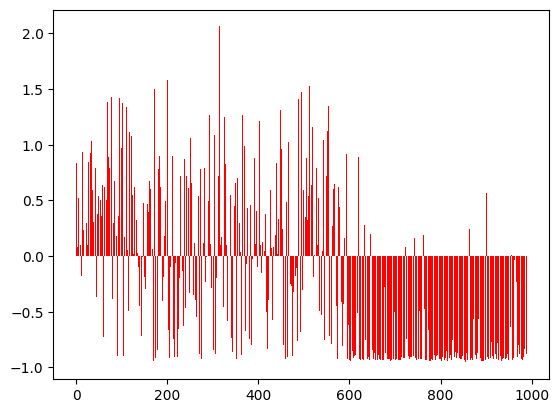

In [16]:
# plt.bar(range(len(seq_list_numpy[:,0])), seq_list_numpy[:,0], color='blue')
plt.bar(range(len(seq_list_numpy_nt)), seq_list_numpy_nt[:,0], color='red')
print(np.max(target_list_numpy))
print(np.min(target_list_numpy))

<BarContainer object of 990 artists>

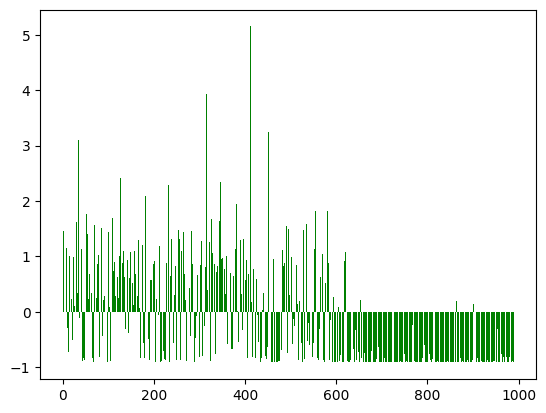

In [17]:
# plt.bar(range(len(target_list_numpy)), target_list_numpy[:,0], color='blue')
plt.bar(range(len(target_list_numpy)), target_list_numpy[:,0], color='green')

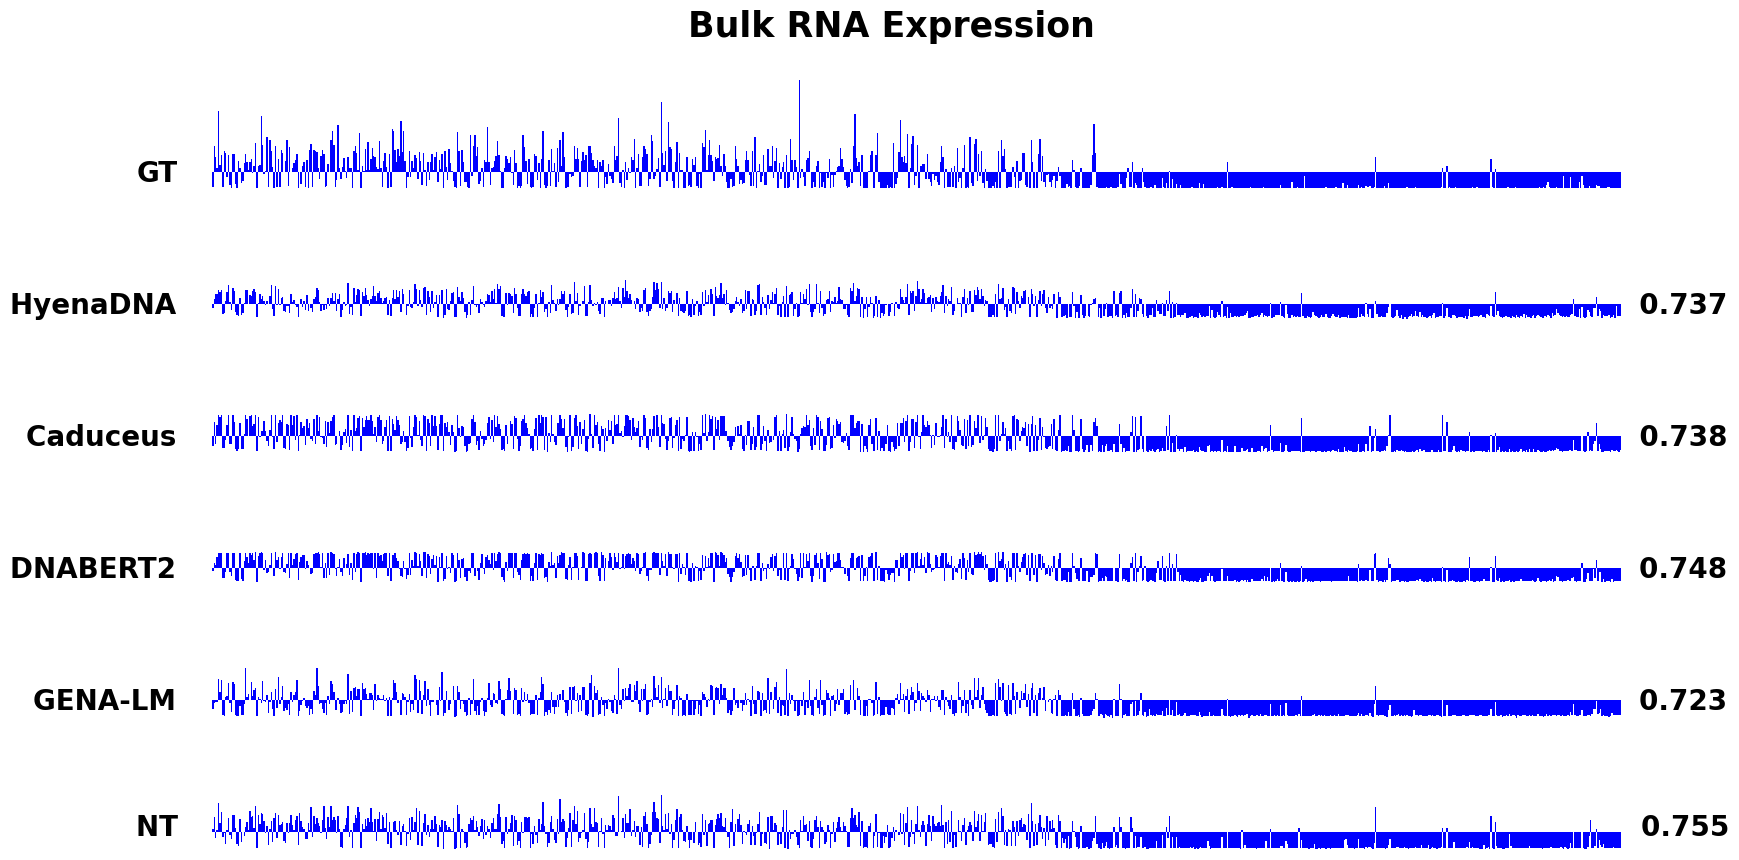

In [18]:
import matplotlib.pyplot as plt
import numpy as np
out_target=target_list_numpy[:,0]
out_hyena_pearsonr=seq_list_numpy_hyena[:,0]
out_nt_pearsonr=seq_list_numpy_nt[:,0]
out_mamba_pearsonr=seq_list_numpy_mamba[:,0]
out_bert2_pearsonr=seq_list_numpy_bert2[:,0]
out_genalm_pearsonr=seq_list_numpy_genalm[:,0]
def spearmanr_numpy(logits,y):
    #compute spearmanr correlation for each class
    output={}

    metrices = []
    spearmanrs = stats.spearmanr(logits, y)[0]
    metrices.append(spearmanrs)
    spearmanrs=np.nanmean(metrices,axis=0)
    output['spearmanr']=spearmanrs
    return spearmanrs

max=np.max([np.max(out_target),np.max(out_hyena_pearsonr),np.max(out_mamba_pearsonr),np.max(out_nt_pearsonr),np.max(out_bert2_pearsonr),np.max(out_genalm_pearsonr)])
min=np.min([np.min(out_target),np.min(out_hyena_pearsonr),np.min(out_mamba_pearsonr),np.min(out_nt_pearsonr),np.min(out_bert2_pearsonr),np.min(out_genalm_pearsonr)])

courses=[]
for i in range(target_list_numpy.shape[0]):
    courses.append(i*0.1)
fig,(ax1,ax2,ax3,ax4,ax5,ax6)=plt.subplots(6,1,figsize=(20,10),sharex=True)

ax1.bar(courses, out_target, color ='blue',  align='edge',
        width = 0.1)
ax1.set_ylim(min,max)
#remove x-axis label
ax1.set_xticklabels([])
#remove y-axis label
ax1.set_yticklabels([])

#remove x-axis ticks
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
#remove y-axis ticks
ax1.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
#remove boundary
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

# ax1_twin = ax1.twinx()
# ax1_twin.set_xticklabels([])
# ax1_twin.set_yticklabels([])
# ax1_twin.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# ax1_twin.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
# ax1_twin.spines['top'].set_visible(False)
# ax1_twin.spines['right'].set_visible(False)
# ax1_twin.spines['bottom'].set_visible(False)
# ax1_twin.spines['left'].set_visible(False)

ax2.bar(courses, out_hyena_pearsonr, color = 'blue', align='edge',
        width = 0.1)
ax2.set_ylim(min,max)
ax2.set_xticklabels([])
#remove y-axis label
ax2.set_yticklabels([])

#remove x-axis ticks
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
#remove y-axis ticks
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
#remove boundary
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

# ax2_twin = ax2.twinx()
# ax2_twin.set_xticklabels([])
# ax2_twin.set_yticklabels([])
# ax2_twin.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# ax2_twin.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
# ax2_twin.spines['top'].set_visible(False)
# ax2_twin.spines['right'].set_visible(False)
# ax2_twin.spines['bottom'].set_visible(False)
# ax2_twin.spines['left'].set_visible(False)

ax3.bar(courses, out_mamba_pearsonr, color = 'blue', align='edge',
        width = 0.1)
ax3.set_ylim(min,max)
ax3.set_xticklabels([])
#remove y-axis label
ax3.set_yticklabels([])

#remove x-axis ticks
ax3.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
#remove y-axis ticks
ax3.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
#remove boundary
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_visible(False)
# ax3_twin = ax3.twinx()
# ax3_twin.set_xticklabels([])
# ax3_twin.set_yticklabels([])
# ax3_twin.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# ax3_twin.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
# ax3_twin.spines['top'].set_visible(False)
# ax3_twin.spines['right'].set_visible(False)
# ax3_twin.spines['bottom'].set_visible(False)
# ax3_twin.spines['left'].set_visible(False)


ax4.bar(courses, out_bert2_pearsonr, color = 'blue', align='edge',
        width = 0.1)
ax4.set_ylim(min,max)
ax4.set_xticklabels([])
#remove y-axis label
ax4.set_yticklabels([])


#remove x-axis ticks
ax4.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)        
#remove y-axis ticks        
ax4.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)        
#remove boundary        
ax4.spines['top'].set_visible(False)        
ax4.spines['right'].set_visible(False)        
ax4.spines['bottom'].set_visible(False)        
ax4.spines['left'].set_visible(False)     

# ax4_twin = ax4.twinx()
# ax4_twin.set_ylim(min,max)
# ax4_twin.set_xticklabels([])
# ax4_twin.set_yticklabels([])
# ax4_twin.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# ax4_twin.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
# ax4_twin.spines['top'].set_visible(False)
# ax4_twin.spines['right'].set_visible(False)
# ax4_twin.spines['bottom'].set_visible(False)
# ax4_twin.spines['left'].set_visible(False)

ax5.bar(courses, out_genalm_pearsonr, color = 'blue', align='edge',
        width = 0.1)
ax5.set_ylim(min,max)
ax5.set_xticklabels([])
#remove y-axis label
ax5.set_yticklabels([])


#remove x-axis ticks
ax5.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)        
#remove y-axis ticks        
ax5.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)        
#remove boundary        
ax5.spines['top'].set_visible(False)        
ax5.spines['right'].set_visible(False)        
ax5.spines['bottom'].set_visible(False)        
ax5.spines['left'].set_visible(False)        


# ax5_twin = ax5.twinx()
# ax5_twin.set_xticklabels([])
# ax5_twin.set_yticklabels([])    

# ax5_twin.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# ax5_twin.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
# ax5_twin.spines['top'].set_visible(False)
# ax5_twin.spines['right'].set_visible(False)
# ax5_twin.spines['bottom'].set_visible(False)
# ax5_twin.spines['left'].set_visible(False)


ax6.bar(courses, out_nt_pearsonr, color = 'blue', align='edge',
        width = 0.1)
ax6.set_ylim(min,max)
ax6.set_xticklabels([])
#remove y-axis label
ax6.set_yticklabels([])


#remove x-axis ticks
ax6.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)        
#remove y-axis ticks        
ax6.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)        
#remove boundary        
ax6.spines['top'].set_visible(False)        
ax6.spines['right'].set_visible(False)        
ax6.spines['bottom'].set_visible(False)        
ax6.spines['left'].set_visible(False)   

# ax6_twin = ax6.twinx()
# # ax6_twin.set_xticklabels([])
# # ax6_twin.set_yticklabels([])
# ax6_twin.get_xaxis().set_ticks([])
# ax6_twin.get_yaxis().set_ticks([])

# # ax6_twin.tick_params(axis='x', which='both', bottom=False, top=False,left=False, right=False, labelbottom=False, labelleft=False)
# # ax6_twin.tick_params(axis='y', which='both', left=False, right=False,bottom=False,top=False, labelleft=False)
# ax6_twin.spines['top'].set_visible(False)
# ax6_twin.spines['right'].set_visible(False)
# ax6_twin.spines['bottom'].set_visible(False)
# ax6_twin.spines['left'].set_visible(False)





ax1.yaxis.set_label_position('left')
ax1.set_ylabel('GT', rotation=0, size=20,fontweight='bold', y=0.15,
                   ha='left', va='center')

ax2.yaxis.set_label_position('left')
ax2.set_ylabel('HyenaDNA'+152*' '+'0.737', rotation=0, size=20,fontweight='bold',y=0.15,
                   ha='left', va='center')
ax2.yaxis.set_label_coords(-0.085,0.15)
# ax2_twin.yaxis.set_label_position('right')
# ax2_twin.set_ylabel(str(spearmanr_numpy(out_hyena_pearsonr,out_target).round(3)), rotation=0, size=20,fontweight='bold',y=0.1,
                    
#                    ha='center', va='center')
ax3.yaxis.set_label_position('left')
ax3.set_ylabel('Caduceus'+152*' '+'0.738', rotation=0, size=20,fontweight='bold',y=0.15,
                   ha='left', va='center')
ax3.yaxis.set_label_coords(-0.075,0.15)
# ax3_twin.yaxis.set_label_position('right')
# ax3_twin.set_ylabel(str(spearmanr_numpy(out_mamba_pearsonr,out_target).round(3)), rotation=0, size=20,fontweight='bold',y=0.1,
                    
#                    ha='center', va='center')
#add y-axis label from both left and right side

ax4.yaxis.set_label_position('left')
ax4.set_ylabel('DNABERT2'+152*' '+'0.748', rotation=0, size=20,fontweight='bold',y=0.15,
                   ha='left', va='center')
ax4.yaxis.set_label_coords(-0.085,0.15)
# ax4_twin.yaxis.set_label_position('right')
# ax4_twin.set_ylabel(str(spearmanr_numpy(out_bert2_pearsonr,out_target).round(3)), rotation=0, size=20,fontweight='bold',y=0.1,
                    
#                    ha='center', va='center')

ax5.yaxis.set_label_position('left')
ax5.set_ylabel('GENA-LM'+152*' '+'0.723', rotation=0, size=20,fontweight='bold',y=0.2,
                   ha='left', va='center')
ax5.yaxis.set_label_coords(-0.07,0.15)
# ax5_twin.yaxis.set_label_position('right')
# ax5_twin.set_ylabel(str(spearmanr_numpy(out_genalm_pearsonr,out_target).round(3)), rotation=0, size=20,fontweight='bold',y=0.1,
                    
#                    ha='center', va='center')

ax6.yaxis.set_label_position('left')
ax6.set_ylabel('NT'+152*' '+'0.755', rotation=0, size=20,fontweight='bold',y=0.2,
                   ha='left', va='center')
# ax6.yaxis.set_label_coords(-0.0,0.1)
# ax6_twin.yaxis.set_label_position('right')
# ax6_twin.set_ylabel(str(spearmanr_numpy(out_nt_pearsonr,out_target).round(3)), rotation=0, size=20,fontweight='bold',y=0.1,
                    
#                    ha='center', va='center')


plt.suptitle('Bulk RNA Expression',fontsize=25,y=0.95,fontweight='bold')
fig.savefig("Bulk_RNA_Expression.pdf", format="pdf", bbox_inches="tight")
plt.show()
#save as pdf


In [19]:
import seaborn as sns

sns.barplot

<function seaborn.categorical.barplot(data=None, *, x=None, y=None, hue=None, order=None, hue_order=None, estimator='mean', errorbar=('ci', 95), n_boot=1000, seed=None, units=None, weights=None, orient=None, color=None, palette=None, saturation=0.75, fill=True, hue_norm=None, width=0.8, dodge='auto', gap=0, log_scale=None, native_scale=False, formatter=None, legend='auto', capsize=0, err_kws=None, ci=<deprecated>, errcolor=<deprecated>, errwidth=<deprecated>, ax=None, **kwargs)>

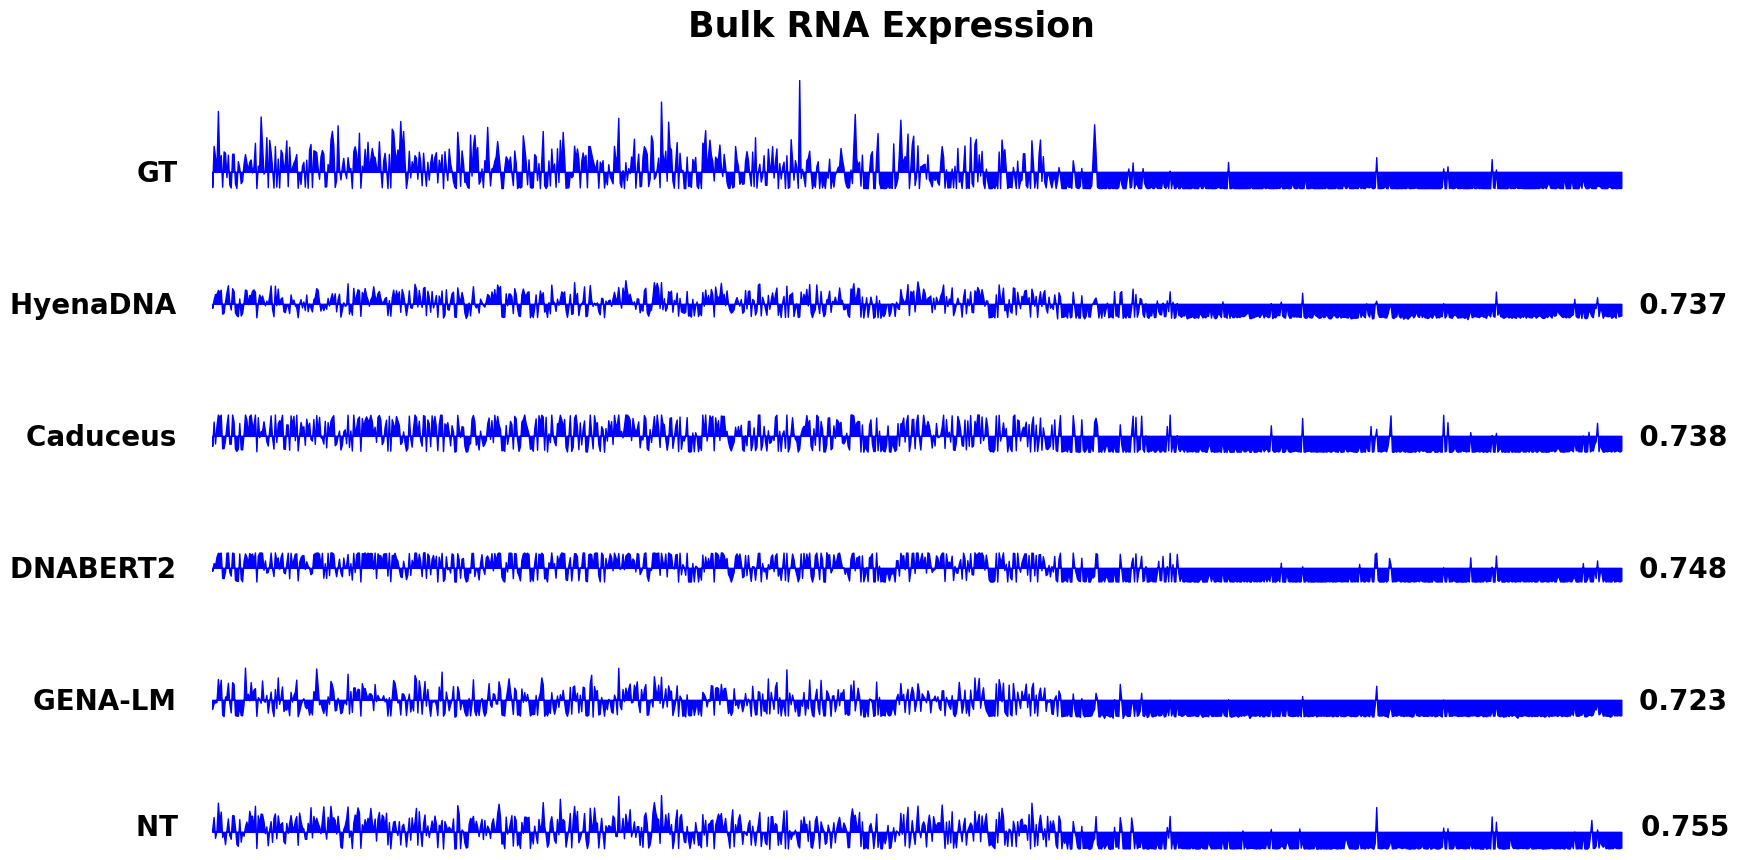

In [20]:
import matplotlib.pyplot as plt
import numpy as np
out_target=target_list_numpy[:,0]
out_hyena_pearsonr=seq_list_numpy_hyena[:,0]
out_nt_pearsonr=seq_list_numpy_nt[:,0]
out_mamba_pearsonr=seq_list_numpy_mamba[:,0]
out_bert2_pearsonr=seq_list_numpy_bert2[:,0]
out_genalm_pearsonr=seq_list_numpy_genalm[:,0]
out_enformer_pearsonr=seq_list_numpy_enformer[:,0]
def spearmanr_numpy(logits,y):
    #compute spearmanr correlation for each class
    output={}

    metrices = []
    spearmanrs = stats.spearmanr(logits, y)[0]
    metrices.append(spearmanrs)
    spearmanrs=np.nanmean(metrices,axis=0)
    output['spearmanr']=spearmanrs
    return spearmanrs

max=np.max([np.max(out_target),np.max(out_hyena_pearsonr),np.max(out_mamba_pearsonr),np.max(out_nt_pearsonr),np.max(out_bert2_pearsonr),np.max(out_genalm_pearsonr)])
min=np.min([np.min(out_target),np.min(out_hyena_pearsonr),np.min(out_mamba_pearsonr),np.min(out_nt_pearsonr),np.min(out_bert2_pearsonr),np.min(out_genalm_pearsonr)])

courses=[]
for i in range(target_list_numpy.shape[0]):
    courses.append(i*0.1)
fig,(ax1,ax2,ax3,ax4,ax5,ax6)=plt.subplots(6,1,figsize=(20,10),sharex=True)

ax1.fill_between(courses, out_target, color ='blue')
ax1.set_ylim(min,max)
#remove x-axis label
ax1.set_xticklabels([])
#remove y-axis label
ax1.set_yticklabels([])

#remove x-axis ticks
ax1.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
#remove y-axis ticks
ax1.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
#remove boundary
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

# ax1_twin = ax1.twinx()
# ax1_twin.set_xticklabels([])
# ax1_twin.set_yticklabels([])
# ax1_twin.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# ax1_twin.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
# ax1_twin.spines['top'].set_visible(False)
# ax1_twin.spines['right'].set_visible(False)
# ax1_twin.spines['bottom'].set_visible(False)
# ax1_twin.spines['left'].set_visible(False)

ax2.fill_between(courses, out_hyena_pearsonr, color = 'blue')
ax2.set_ylim(min,max)
ax2.set_xticklabels([])
#remove y-axis label
ax2.set_yticklabels([])

#remove x-axis ticks
ax2.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
#remove y-axis ticks
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
#remove boundary
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)

# ax2_twin = ax2.twinx()
# ax2_twin.set_xticklabels([])
# ax2_twin.set_yticklabels([])
# ax2_twin.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# ax2_twin.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
# ax2_twin.spines['top'].set_visible(False)
# ax2_twin.spines['right'].set_visible(False)
# ax2_twin.spines['bottom'].set_visible(False)
# ax2_twin.spines['left'].set_visible(False)

ax3.fill_between(courses, out_mamba_pearsonr, color = 'blue')
ax3.set_ylim(min,max)
ax3.set_xticklabels([])
#remove y-axis label
ax3.set_yticklabels([])

#remove x-axis ticks
ax3.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
#remove y-axis ticks
ax3.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
#remove boundary
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.spines['bottom'].set_visible(False)
ax3.spines['left'].set_visible(False)
# ax3_twin = ax3.twinx()
# ax3_twin.set_xticklabels([])
# ax3_twin.set_yticklabels([])
# ax3_twin.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# ax3_twin.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
# ax3_twin.spines['top'].set_visible(False)
# ax3_twin.spines['right'].set_visible(False)
# ax3_twin.spines['bottom'].set_visible(False)
# ax3_twin.spines['left'].set_visible(False)


ax4.fill_between(courses, out_bert2_pearsonr, color = 'blue')
ax4.set_ylim(min,max)
ax4.set_xticklabels([])
#remove y-axis label
ax4.set_yticklabels([])


#remove x-axis ticks
ax4.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)        
#remove y-axis ticks        
ax4.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)        
#remove boundary        
ax4.spines['top'].set_visible(False)        
ax4.spines['right'].set_visible(False)        
ax4.spines['bottom'].set_visible(False)        
ax4.spines['left'].set_visible(False)     

# ax4_twin = ax4.twinx()
# ax4_twin.set_ylim(min,max)
# ax4_twin.set_xticklabels([])
# ax4_twin.set_yticklabels([])
# ax4_twin.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# ax4_twin.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
# ax4_twin.spines['top'].set_visible(False)
# ax4_twin.spines['right'].set_visible(False)
# ax4_twin.spines['bottom'].set_visible(False)
# ax4_twin.spines['left'].set_visible(False)

ax5.fill_between(courses, out_genalm_pearsonr, color = 'blue')
ax5.set_ylim(min,max)
ax5.set_xticklabels([])
#remove y-axis label
ax5.set_yticklabels([])


#remove x-axis ticks
ax5.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)        
#remove y-axis ticks        
ax5.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)        
#remove boundary        
ax5.spines['top'].set_visible(False)        
ax5.spines['right'].set_visible(False)        
ax5.spines['bottom'].set_visible(False)        
ax5.spines['left'].set_visible(False)        


# ax5_twin = ax5.twinx()
# ax5_twin.set_xticklabels([])
# ax5_twin.set_yticklabels([])    

# ax5_twin.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
# ax5_twin.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
# ax5_twin.spines['top'].set_visible(False)
# ax5_twin.spines['right'].set_visible(False)
# ax5_twin.spines['bottom'].set_visible(False)
# ax5_twin.spines['left'].set_visible(False)


ax6.fill_between(courses, out_nt_pearsonr, color = 'blue')
ax6.set_ylim(min,max)
ax6.set_xticklabels([])
#remove y-axis label
ax6.set_yticklabels([])


#remove x-axis ticks
ax6.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)        
#remove y-axis ticks        
ax6.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)        
#remove boundary        
ax6.spines['top'].set_visible(False)        
ax6.spines['right'].set_visible(False)        
ax6.spines['bottom'].set_visible(False)        
ax6.spines['left'].set_visible(False)   

# ax7.fill_between(courses, out_enformer_pearsonr, color = 'blue')
# ax7.set_ylim(min,max)
# ax7.set_xticklabels([])
# #remove y-axis label
# ax7.set_yticklabels([])


#remove x-axis ticks
# ax7.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)        
# #remove y-axis ticks        
# ax7.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)        
# #remove boundary        
# ax7.spines['top'].set_visible(False)        
# ax7.spines['right'].set_visible(False)        
# ax7.spines['bottom'].set_visible(False)        
# ax7.spines['left'].set_visible(False)   


# ax7_twin = ax7.twinx()
# ax7_twin.set_xticklabels([])
# ax6_twin = ax6.twinx()
# # ax6_twin.set_xticklabels([])
# # ax6_twin.set_yticklabels([])
# ax6_twin.get_xaxis().set_ticks([])
# ax6_twin.get_yaxis().set_ticks([])

# # ax6_twin.tick_params(axis='x', which='both', bottom=False, top=False,left=False, right=False, labelbottom=False, labelleft=False)
# # ax6_twin.tick_params(axis='y', which='both', left=False, right=False,bottom=False,top=False, labelleft=False)
# ax6_twin.spines['top'].set_visible(False)
# ax6_twin.spines['right'].set_visible(False)
# ax6_twin.spines['bottom'].set_visible(False)
# ax6_twin.spines['left'].set_visible(False)





ax1.yaxis.set_label_position('left')
ax1.set_ylabel('GT', rotation=0, size=20,fontweight='bold', y=0.15,
                   ha='left', va='center')

ax2.yaxis.set_label_position('left')
ax2.set_ylabel('HyenaDNA'+152*' '+'0.737', rotation=0, size=20,fontweight='bold',y=0.15,
                   ha='left', va='center')
ax2.yaxis.set_label_coords(-0.085,0.15)
# ax2_twin.yaxis.set_label_position('right')
# ax2_twin.set_ylabel(str(spearmanr_numpy(out_hyena_pearsonr,out_target).round(3)), rotation=0, size=20,fontweight='bold',y=0.1,
                    
#                    ha='center', va='center')
ax3.yaxis.set_label_position('left')
ax3.set_ylabel('Caduceus'+152*' '+'0.738', rotation=0, size=20,fontweight='bold',y=0.15,
                   ha='left', va='center')
ax3.yaxis.set_label_coords(-0.075,0.15)
# ax3_twin.yaxis.set_label_position('right')
# ax3_twin.set_ylabel(str(spearmanr_numpy(out_mamba_pearsonr,out_target).round(3)), rotation=0, size=20,fontweight='bold',y=0.1,
                    
#                    ha='center', va='center')
#add y-axis label from both left and right side

ax4.yaxis.set_label_position('left')
ax4.set_ylabel('DNABERT2'+152*' '+'0.748', rotation=0, size=20,fontweight='bold',y=0.15,
                   ha='left', va='center')
ax4.yaxis.set_label_coords(-0.085,0.15)
# ax4_twin.yaxis.set_label_position('right')
# ax4_twin.set_ylabel(str(spearmanr_numpy(out_bert2_pearsonr,out_target).round(3)), rotation=0, size=20,fontweight='bold',y=0.1,
                    
#                    ha='center', va='center')

ax5.yaxis.set_label_position('left')
ax5.set_ylabel('GENA-LM'+152*' '+'0.723', rotation=0, size=20,fontweight='bold',y=0.2,
                   ha='left', va='center')
ax5.yaxis.set_label_coords(-0.07,0.15)
# ax5_twin.yaxis.set_label_position('right')
# ax5_twin.set_ylabel(str(spearmanr_numpy(out_genalm_pearsonr,out_target).round(3)), rotation=0, size=20,fontweight='bold',y=0.1,
                    
#                    ha='center', va='center')

ax6.yaxis.set_label_position('left')
ax6.set_ylabel('NT'+152*' '+'0.755', rotation=0, size=20,fontweight='bold',y=0.2,
                   ha='left', va='center')
# ax6.yaxis.set_label_coords(-0.0,0.1)
# ax6_twin.yaxis.set_label_position('right')
# ax6_twin.set_ylabel(str(spearmanr_numpy(out_nt_pearsonr,out_target).round(3)), rotation=0, size=20,fontweight='bold',y=0.1,
                    
#                    ha='center', va='center')

# ax7.yaxis.set_label_position('left')
# ax7.set_ylabel('Enformer'+152*' '+'0.744', rotation=0, size=20,fontweight='bold',y=0.2,
#                    ha='left', va='center')
plt.suptitle('Bulk RNA Expression',fontsize=25,y=0.95,fontweight='bold')
fig.savefig("Bulk_RNA_Expression.pdf", format="pdf", bbox_inches="tight")
fig.savefig("Bulk_RNA_Expression.png", format="png", bbox_inches="tight")
plt.show()
#save as pdf
